In [1]:
import sys
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import scipy.stats as stats
import seaborn as sns
sys.path.append("H:\chcd_py")
from functools import wraps
from chcd_py.helpers.sql_logger import get_dsn

In [30]:
def profile(fn):
    @wraps(fn)
    def inner(*args, **kwargs):
        fn_kwargs_str = ', '.join(f'{k}={v}' for k, v in kwargs.items())
        print(f'\n{fn.__name__}({fn_kwargs_str})')
        
        t = time.perf_counter()
        retval = fn(*args, **kwargs)
        print(f'result: {retval[0][0]:,}')
        elapsed = time.perf_counter() - t
        print(f'Time {elapsed:0.4}')
        
        return elapsed
    return inner


@profile
def dx_equal_query(cursor, table, arg):
    '''performs a simple count equal query'''
    cursor.execute(f'select count(*) from {table} where diag_cd = %s', (arg, ))
    return cursor.fetchall()

@profile
def dx_in_query(cursor, table, arg):
    cursor.execute(f'select count(*) from {table} where diag_cd in (%s, %s, %s)', arg)
    return cursor.fetchall()


@profile
def dx_join_query(cursor, table, arg):
    cursor.execute('drop table if exists dev.gm_dx_temp;')
    cursor.execute(f"""
create table dev.gm_dx_temp as 
select * from reference_tables.ref_cms_icd_cm_codes rcicc 
where cd_value like %s ESCAPE ''""", 
                   (arg,))
    cursor.execute(f'''select count(*) from {table} as dx
    inner join dev.gm_dx_temp tmp on dx.diag_cd = tmp.cd_value;''', (arg, ))
    return cursor.fetchall()

def query_comparison_profiler(con, table_col_list, profile_function, arg_list):
    '''
    con: database connection
    table_list: list of tables that will be compared
    profile_function: function that executes a query; this must return a time elapsed in seconds
    arg_list: list of arguments that will be ran in the query
    '''
    count = 1
    total_run_count = len(table_col_list)*len(arg_list)
    results_dict = {}
    for table in table_col_list:
        results_dict[table] = []
        for arg in arg_list:
            print(f"\nRUN #: {count}/{total_run_count}", end='')
            count+=1
            with con.cursor() as cursor:
                arg = profile_function(cursor, table, arg=arg)
                results_dict[table].append(arg)
        
        
    results_df = pd.DataFrame(results_dict)

    results_melt_df = pd.melt(results_df.reset_index(), id_vars=['index'], 
                              value_vars=table_col_list)
    results_melt_df.columns = ['index', 'table', 'seconds']
    
    plt.rcParams['figure.figsize'] = [10,5]
    sns.boxplot(x='table',y='seconds',data=results_melt_df)
    
    return results_df

In [3]:
#random codes to compare diagnosis codes

dx_codes = ['05410', 'J050', '2724', 'M79672', '4720', 'Z7982',
            'H4010X1', 'Z3492', 'R41841', '6101','F519', 'Z30432',
            'S83412A','C8296', 'K654', 'T8484XA', '4739', 'M5137',
            '49390', 'V0489']

np.random.seed(0)
dx_codes_combo = list(itertools.combinations(dx_codes,3))
np.random.shuffle(dx_codes_combo)
dx_codes_combo = dx_codes_combo[:20]
dx_codes_combo

[('6101', '4739', 'M5137'),
 ('Z3492', 'F519', 'K654'),
 ('Z30432', 'K654', '4739'),
 ('J050', '2724', '4739'),
 ('Z7982', 'H4010X1', 'Z3492'),
 ('R41841', 'F519', 'M5137'),
 ('M79672', 'K654', 'M5137'),
 ('Z3492', 'Z30432', 'V0489'),
 ('Z30432', '49390', 'V0489'),
 ('M79672', 'K654', 'V0489'),
 ('05410', 'Z7982', 'T8484XA'),
 ('05410', 'J050', '4739'),
 ('Z7982', 'Z3492', '4739'),
 ('Z3492', 'K654', 'T8484XA'),
 ('J050', 'H4010X1', 'K654'),
 ('J050', 'M79672', 'R41841'),
 ('M79672', 'Z7982', '49390'),
 ('4720', 'R41841', '4739'),
 ('J050', 'S83412A', 'T8484XA'),
 ('Z7982', 'S83412A', 'V0489')]

## Tables

<p>
dw_staging.claim_diag_wc: No removed rows; btree index on diag_cd <br>
    
dw_staging.claim_diag_clean_wc: Removed non-matching icd codes; bitmap index on diag_cd <br>
    
data_warehouse.claim_diag: No removed rows; no index
</p>

DDL SQL Code

```
CREATE TABLE dw_staging.claim_diag_wc (
	data_source text NULL,
	uth_member_id int8 NULL,
	uth_claim_id int8 NULL,
	claim_sequence_number int4 NULL,
	from_date_of_service date NULL,
	diag_cd text NULL,
	diag_position int4 NULL,
	poa_src text NULL
)
WITH (
	appendonly=true,
	orientation=column,
	checksum=true,
	compresslevel=5,
	compresstype=zlib
)
DISTRIBUTED BY (uth_member_id);
CREATE INDEX claim_diag_wc_idx ON dw_staging.claim_diag_wc USING btree (diag_cd);



CREATE TABLE dw_staging.claim_diag_clean_wc (
	data_source text NULL,
	uth_member_id int8 NULL,
	uth_claim_id int8 NULL,
	claim_sequence_number int4 NULL,
	from_date_of_service date NULL,
	diag_cd text NULL,
	diag_position int4 NULL,
	poa_src text NULL
)
WITH (
	appendonly=true,
	orientation=column,
	checksum=true,
	compresslevel=5,
	compresstype=zlib
)
DISTRIBUTED BY (uth_member_id);
CREATE INDEX claim_diag_clean_wc_idx ON dw_staging.claim_diag_clean_wc USING bitmap (diag_cd);

CREATE TABLE data_warehouse.claim_diag (
	data_source text NULL,
	uth_member_id int8 NULL,
	uth_claim_id int8 NULL,
	claim_sequence_number int4 NULL,
	from_date_of_service date NULL,
	diag_cd text NULL,
	diag_position int4 NULL,
	poa_src text NULL
)
WITH (
	appendonly=true,
	orientation=column,
	checksum=true,
	compresslevel=5,
	compresstype=zlib
)
DISTRIBUTED BY (uth_member_id);

```


In [4]:
con = psycopg2.connect(get_dsn())
con.autocommit = True

# Select count(\*) from {dx_table} where diag_cd = X; 


dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=05410)
result: 2,006,364
Time 2.479

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=J050)
result: 3,171,560
Time 3.227

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=2724)
result: 529,278,261
Time 12.59

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=M79672)
result: 31,990,642
Time 10.19

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=4720)
result: 11,361,679
Time 6.545

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=Z7982)
result: 195,456,496
Time 10.56

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=H4010X1)
result: 353,483
Time 0.6007

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=Z3492)
result: 1,955,643
Time 2.355

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=R41841)
result: 48,721,965
Time 4.086

dx_equal_query(table=dw_staging.claim_diag_clean_wc, arg=6101)
result: 7,815,775
Time 5.626

dx_equal_query(table=dw_staging.claim_diag_clean_wc, 

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
0,2.479308,12.961223,149.134594
1,3.227250,17.061797,106.192018
2,12.594668,49.014038,69.856726
3,10.188599,45.360845,94.610796
4,6.544926,32.616040,70.060269
5,10.561963,77.290002,68.880351
6,0.600667,1.096605,67.487389
7,2.355028,3.829659,68.917038
8,4.085621,52.829758,64.699624
9,5.626476,42.925734,69.564865


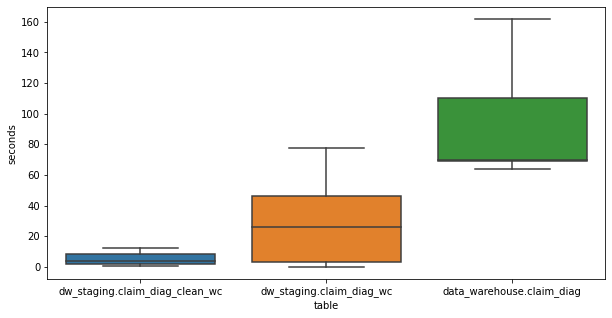

In [5]:

table_list = ['dw_staging.claim_diag_clean_wc', 
              'dw_staging.claim_diag_wc', 
              'data_warehouse.claim_diag']

dx_equal_results = query_comparison_profiler(con, table_list, dx_equal_query, dx_codes)
dx_equal_results

In [9]:
dx_equal_description = dx_equal_results.describe()
dx_equal_description

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
count,20.000000,20.000000,20.000000
mean,4.984340,27.200881,90.665634
std,3.969468,22.708847,33.450964
min,0.216926,0.187669,63.858331
25%,2.046619,3.433351,68.907866
50%,3.656436,26.053856,69.958497
75%,8.417777,46.174498,110.045705
max,12.594668,77.290002,161.519424


In [18]:
(dx_equal_description.loc['mean']-dx_equal_description.loc['mean'].max())/dx_equal_description.loc['mean'].max()

dw_staging.claim_diag_clean_wc   -0.945025
dw_staging.claim_diag_wc         -0.699987
data_warehouse.claim_diag         0.000000
Name: mean, dtype: float64

In [16]:

fvalue, pvalue = stats.f_oneway(dx_equal_results['dw_staging.claim_diag_clean_wc'], 
                                dx_equal_results['dw_staging.claim_diag_wc'], 
                                dx_equal_results['data_warehouse.claim_diag'])
print(fvalue, pvalue)

71.87665499020028 2.609432225254548e-16


# Select count(\*) from {dx_table} where diag_cd in (X, X, X); 

RUN #: 1/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('6101', '4739', 'M5137'))
result: 56,852,700
Time 31.24
RUN #: 2/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('Z3492', 'F519', 'K654'))
result: 2,539,664
Time 5.926
RUN #: 3/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('Z30432', 'K654', '4739'))
result: 30,781,269
Time 20.68
RUN #: 4/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('J050', '2724', '4739'))
result: 561,110,883
Time 30.82
RUN #: 5/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('Z7982', 'H4010X1', 'Z3492'))
result: 197,765,622
Time 24.64
RUN #: 6/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('R41841', 'F519', 'M5137'))
result: 69,380,885
Time 23.77
RUN #: 7/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('M79672', 'K654', 'M5137'))
result: 52,667,469
Time 24.57
RUN #: 8/60

dx_in_query(table=dw_staging.claim_diag_clean_wc, arg=('Z3492', 'Z30432', 'V0489'))
result: 33,391,459
Time 18

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
0,31.242846,102.757690,239.185813
1,5.926431,15.545679,226.507066
2,20.679933,42.358238,125.763246
3,30.816572,59.316341,198.199620
4,24.635661,75.723780,202.014139
5,23.770681,58.337507,157.258919
6,24.571683,162.289530,196.950873
7,18.699525,105.552944,196.136806
8,23.123980,153.919977,184.940287
9,27.414025,215.885204,185.908637


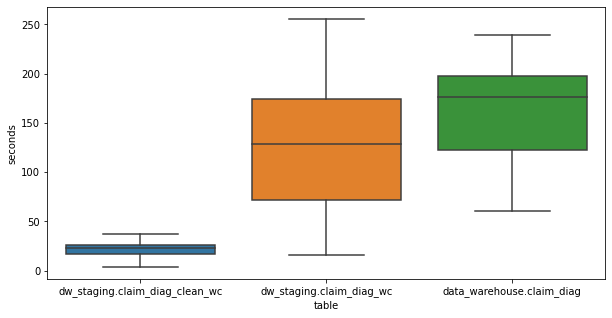

In [17]:

dx_in_results = query_comparison_profiler(con, table_list, dx_in_query, dx_codes_combo)
dx_in_results

In [19]:
dx_in_results.describe()

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
count,20.000000,20.000000,20.000000
mean,21.127619,128.643523,159.583763
std,9.193369,68.414052,52.620031
min,4.187597,15.545679,60.087300
25%,16.771455,71.621920,122.103779
50%,23.447331,128.578432,176.220732
75%,25.928668,174.488019,197.263060
max,37.370638,255.059599,239.185813


In [20]:

fvalue, pvalue = stats.f_oneway(dx_in_results['dw_staging.claim_diag_clean_wc'], 
                                dx_in_results['dw_staging.claim_diag_wc'], 
                                dx_in_results['data_warehouse.claim_diag'])
print(fvalue, pvalue)

42.05949786905249 6.015161430559905e-12


# select count(\*) from {table} as dx inner join dev.gm_dx_temp tmp on dx.diag_cd = tmp.cd_value;

RUN #: 1/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=054%)
result: 9,291,418
Time 13.55
RUN #: 2/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=J05%)
result: 3,320,525
Time 3.703
RUN #: 3/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=272%)
result: 847,678,686
Time 50.99
RUN #: 4/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=M79%)
result: 333,991,646
Time 156.8
RUN #: 5/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=472%)
result: 12,406,527
Time 8.129
RUN #: 6/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=Z79%)
result: 1,323,941,114
Time 108.1
RUN #: 7/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=H40%)
result: 107,032,809
Time 123.4
RUN #: 8/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=Z34%)
result: 49,024,425
Time 37.8
RUN #: 9/60

dx_join_query(table=dw_staging.claim_diag_clean_wc, arg=R41%)
result: 153,357,765
Time 39.08
RUN #: 10/60

dx_join_query(table=dw_staging.claim_

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
0,13.553722,34.801215,106.232709
1,3.703117,17.598919,107.859098
2,50.992084,217.066305,108.666693
3,156.785043,901.318893,107.458174
4,8.128586,33.819651,108.691739
5,108.139498,597.326269,124.195430
6,123.390798,109.115181,107.526943
7,37.803934,172.120331,107.005671
8,39.082549,236.352404,107.173197
9,14.315958,40.868241,108.062178


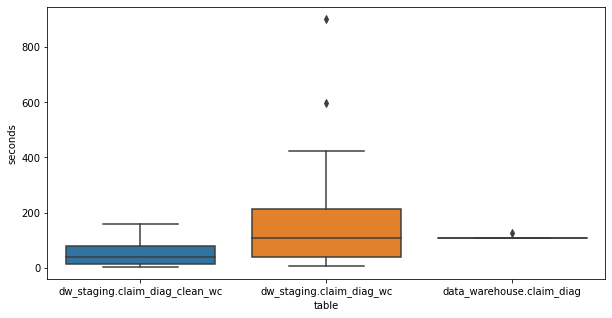

In [21]:
like_dx_codes = [i[:3]+'%' for i in dx_codes]

dx_join_results = query_comparison_profiler(con, table_list, dx_join_query, like_dx_codes)
dx_join_results

In [23]:
dx_join_results.describe()

,dw_staging.claim_diag_clean_wc,dw_staging.claim_diag_wc,data_warehouse.claim_diag
count,20.000000,20.000000,20.000000
mean,51.283495,183.433304,108.280777
std,48.076114,222.572739,3.810616
min,3.703117,5.353224,106.232709
25%,14.125399,39.351484,106.970170
50%,37.964410,108.582224,107.461927
75%,76.551448,213.284452,108.074449
max,156.785043,901.318893,124.195430


In [24]:

fvalue, pvalue = stats.f_oneway(dx_join_results['dw_staging.claim_diag_clean_wc'], 
                                dx_join_results['dw_staging.claim_diag_wc'], 
                                dx_join_results['data_warehouse.claim_diag'])
print(fvalue, pvalue)

5.082510385632338 0.009307938709991494


### bitmap 200k vs 100k comparison

<p>
claim_diag_final_wc: two **bitmap** indicies; one on the cleaned column diag_cd_clean which has ~200k values<br>
    one is the original column diag_cd with 200k unique values
</p>

```
CREATE TABLE dw_staging.claim_diag_final_wc (
	data_source text NULL,
	uth_member_id int8 NULL,
	uth_claim_id int8 NULL,
	claim_sequence_number int4 NULL,
	from_date_of_service date NULL,
	diag_cd text NULL,
	diag_position int4 NULL,
	poa_src text NULL,
	diag_cd_clean text NULL
)
WITH (
	appendonly=true,
	orientation=column,
	checksum=true,
	compresslevel=5,
	compresstype=zlib
)
DISTRIBUTED BY (uth_member_id);
CREATE INDEX claim_diag_final_100_ix ON dw_staging.claim_diag_final_wc USING bitmap (diag_cd_clean);
CREATE INDEX claim_diag_final_200_ix ON dw_staging.claim_diag_final_wc USING bitmap (diag_cd);

delete from  dw_staging.claim_diag_final_wc where diag_cd_clean not in (select cd_value from reference_tables.ref_cms_icd_cm_codes );

```

In [35]:

@profile
def dx_bitmap_equal_query(cursor, col, arg):
    cursor.execute(f'select count(*) from dw_staging.claim_diag_final_wc where {col} = %s', (arg, ))
    return cursor.fetchall()


@profile
def dx_bitmap_in_query(cursor, col, arg):
    cursor.execute(f'select count(*) from dw_staging.claim_diag_final_wc where {col} in (%s, %s, %s)', arg)
    return cursor.fetchall()


@profile
def dx_bitmap_join_query(cursor, col, arg):
    cursor.execute('drop table if exists dev.gm_dx_temp;')
    cursor.execute(f"""
create table dev.gm_dx_temp as 
select * from reference_tables.ref_cms_icd_cm_codes rcicc 
where cd_value like %s ESCAPE ''""", 
                   (arg,))
    cursor.execute(f'''select count(*) from dw_staging.claim_diag_final_wc as dx
    inner join dev.gm_dx_temp tmp on dx.{col} = tmp.cd_value;''', (arg, ))
    return cursor.fetchall()


RUN #: 1/40
dx_bitmap_equal_query(arg=05410)
result: 2,006,366
Time 2.156

RUN #: 2/40
dx_bitmap_equal_query(arg=J050)
result: 3,171,560
Time 3.157

RUN #: 3/40
dx_bitmap_equal_query(arg=2724)
result: 529,278,335
Time 12.18

RUN #: 4/40
dx_bitmap_equal_query(arg=M79672)
result: 31,990,648
Time 9.9

RUN #: 5/40
dx_bitmap_equal_query(arg=4720)
result: 11,361,683
Time 6.397

RUN #: 6/40
dx_bitmap_equal_query(arg=Z7982)
result: 195,456,496
Time 10.33

RUN #: 7/40
dx_bitmap_equal_query(arg=H4010X1)
result: 353,483
Time 0.5279

RUN #: 8/40
dx_bitmap_equal_query(arg=Z3492)
result: 1,955,643
Time 2.307

RUN #: 9/40
dx_bitmap_equal_query(arg=R41841)
result: 48,721,965
Time 3.856

RUN #: 10/40
dx_bitmap_equal_query(arg=6101)
result: 7,815,781
Time 5.279

RUN #: 11/40
dx_bitmap_equal_query(arg=F519)
result: 283,057
Time 0.4553

RUN #: 12/40
dx_bitmap_equal_query(arg=Z30432)
result: 1,819,243
Time 2.515

RUN #: 13/40
dx_bitmap_equal_query(arg=S83412A)
result: 693,749
Time 1.111

RUN #: 14/40
dx_b

,diag_cd,diag_cd_clean
0,2.155690,2.435902
1,3.156825,3.536881
2,12.177480,12.551963
3,9.900055,10.119661
4,6.397003,6.390517
5,10.326998,10.230319
6,0.527886,0.592264
7,2.306863,2.266060
8,3.856218,3.923774
9,5.279211,5.275737


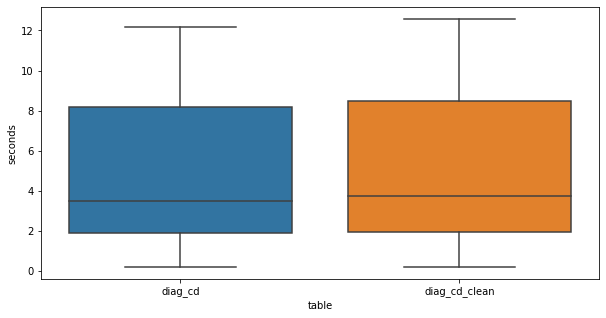

In [39]:
col_list = ['diag_cd', 'diag_cd_clean']

dx_bitmap_equal_results = query_comparison_profiler(con, col_list, dx_bitmap_equal_query, dx_codes)
dx_bitmap_equal_results

In [40]:
dx_bitmap_equal_results.describe()

,diag_cd,diag_cd_clean
count,20.000000,20.000000
mean,4.832033,4.919315
std,3.866464,3.959083
min,0.209945,0.210044
25%,1.894578,1.915939
50%,3.506522,3.730328
75%,8.176480,8.488982
max,12.177480,12.551963


In [43]:

tvalue, pvalue = stats.ttest_rel(dx_bitmap_equal_results['diag_cd'], 
                                dx_bitmap_equal_results['diag_cd_clean'])
print(tvalue, pvalue)

-1.8875405747064091 0.0744594247224912


## in query


RUN #: 1/40
dx_bitmap_in_query(arg=('6101', '4739', 'M5137'))
result: 56,852,722
Time 11.99

RUN #: 2/40
dx_bitmap_in_query(arg=('Z3492', 'F519', 'K654'))
result: 2,539,664
Time 2.949

RUN #: 3/40
dx_bitmap_in_query(arg=('Z30432', 'K654', '4739'))
result: 30,781,285
Time 9.062

RUN #: 4/40
dx_bitmap_in_query(arg=('J050', '2724', '4739'))
result: 561,110,973
Time 13.02

RUN #: 5/40
dx_bitmap_in_query(arg=('Z7982', 'H4010X1', 'Z3492'))
result: 197,765,622
Time 10.89

RUN #: 6/40
dx_bitmap_in_query(arg=('R41841', 'F519', 'M5137'))
result: 69,380,885
Time 9.781

RUN #: 7/40
dx_bitmap_in_query(arg=('M79672', 'K654', 'M5137'))
result: 52,667,475
Time 11.1

RUN #: 8/40
dx_bitmap_in_query(arg=('Z3492', 'Z30432', 'V0489'))
result: 33,391,485
Time 7.922

RUN #: 9/40
dx_bitmap_in_query(arg=('Z30432', '49390', 'V0489'))
result: 120,591,141
Time 10.67

RUN #: 10/40
dx_bitmap_in_query(arg=('M79672', 'K654', 'V0489'))
result: 61,908,211
Time 11.78

RUN #: 11/40
dx_bitmap_in_query(arg=('05410', 'Z798

,diag_cd,diag_cd_clean
0,11.985529,12.262337
1,2.948938,2.438304
2,9.061845,9.369564
3,13.023985,13.075418
4,10.890963,10.910467
5,9.780873,9.946257
6,11.097873,11.362612
7,7.921731,8.050077
8,10.672964,10.713684
9,11.778730,11.830827


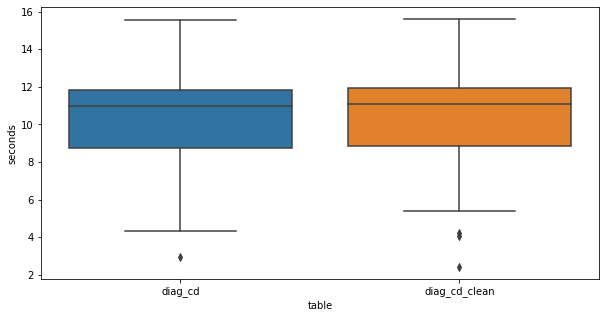

In [44]:

dx_bitmap_in_results = query_comparison_profiler(con, col_list, dx_bitmap_in_query, dx_codes_combo)
dx_bitmap_in_results

In [46]:
dx_bitmap_in_results.describe()

,diag_cd,diag_cd_clean
count,20.000000,20.000000
mean,10.004769,9.989855
std,3.401303,3.535478
min,2.948938,2.438304
25%,8.730560,8.858010
50%,10.994418,11.069743
75%,11.830430,11.938705
max,15.574649,15.587013


In [45]:

tvalue, pvalue = stats.ttest_rel(dx_bitmap_in_results['diag_cd'], 
                                dx_bitmap_in_results['diag_cd_clean'])
print(tvalue, pvalue)

0.2970640609440925 0.7696408954711261


## Join


RUN #: 1/40
dx_bitmap_join_query(arg=054%)
result: 9,291,442
Time 8.973

RUN #: 2/40
dx_bitmap_join_query(arg=J05%)
result: 3,321,173
Time 3.319

RUN #: 3/40
dx_bitmap_join_query(arg=272%)
result: 847,678,882
Time 50.66

RUN #: 4/40
dx_bitmap_join_query(arg=M79%)
result: 355,127,702
Time 158.2

RUN #: 5/40
dx_bitmap_join_query(arg=472%)
result: 12,406,531
Time 7.88

RUN #: 6/40
dx_bitmap_join_query(arg=Z79%)
result: 1,324,007,373
Time 102.7

RUN #: 7/40
dx_bitmap_join_query(arg=H40%)
result: 114,663,155
Time 149.9

RUN #: 8/40
dx_bitmap_join_query(arg=Z34%)
result: 49,029,716
Time 35.96

RUN #: 9/40
dx_bitmap_join_query(arg=R41%)
result: 153,363,105
Time 37.03

RUN #: 10/40
dx_bitmap_join_query(arg=610%)
result: 15,894,755
Time 13.48

RUN #: 11/40
dx_bitmap_join_query(arg=F51%)
result: 18,718,300
Time 13.66

RUN #: 12/40
dx_bitmap_join_query(arg=Z30%)
result: 37,746,799
Time 35.76

RUN #: 13/40
dx_bitmap_join_query(arg=S83%)
result: 40,664,280
Time 149.4

RUN #: 14/40
dx_bitmap_join_q

,diag_cd,diag_cd_clean
0,8.973090,8.778041
1,3.318973,3.345437
2,50.657441,49.174882
3,158.182359,157.169945
4,7.880062,7.810265
5,102.673281,101.993475
6,149.865057,147.938135
7,35.955062,35.765639
8,37.028152,36.881048
9,13.484102,13.640957


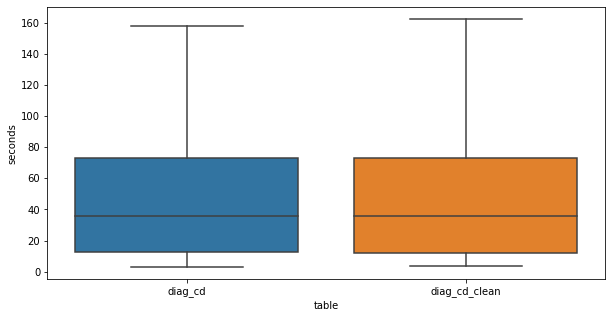

In [47]:

dx_bitmap_join_results = query_comparison_profiler(con, col_list, dx_bitmap_join_query, like_dx_codes)
dx_bitmap_join_results

In [48]:
dx_bitmap_join_results.describe()

,diag_cd,diag_cd_clean
count,20.000000,20.000000
mean,54.053332,54.469323
std,55.147520,56.256464
min,3.318973,3.345437
25%,12.356349,12.298861
50%,35.855340,35.550094
75%,73.388328,73.210746
max,158.182359,162.109185


In [49]:

tvalue, pvalue = stats.ttest_rel(dx_bitmap_join_results['diag_cd'], 
                                dx_bitmap_join_results['diag_cd_clean'])
print(tvalue, pvalue)

-0.6246266975076834 0.5396452681453827
